Explanations of these results can be found in the pdf document in the same github repository.

In [1]:
import pandas as pd
import numpy as np

#Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import neighbors
from sklearn.neural_network import MLPClassifier

#Resampling techniques
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#Performance metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import warnings
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.inspection import permutation_importance

In [2]:
#Import csv table of variables
df = pd.read_csv(r'C:\Users\laura\OneDrive\TFM\data_preprocessed.csv')

#### DATA EXPLORATION AND PREPARATION

In [3]:
df.shape

(5598, 33)

In [5]:
df.head(10)

Unnamed: 0  id_user  age  sum_physical_health  sum_cognitive_function  \
0           0    20164   30                    0                      60   
1           1    41034   51                    6                      59   
2           2    41064   45                    8                      60   
3           3    41249   51                   11                      57   
4           4    42051   58                    3                      52   
5           5    42073   54                    8                      49   
6           6    42147   47                    1                      54   
7           7    42173   47                   11                      55   
8           8    42195   43                    1                      56   
9           9    42217   32                    4                      38   

   gender  sum_global_health  sum_smoking  marital_status  \
0       1                 38            0               1   
1       1                 48            0               1   
2       2                 50            0               1   
3       1                 43            0               4   
4       2                 35            0               2   
5       2                 33           26               4   
6       1                 36            0               1   
7       1                 29            5               1   
8       2                 43            4               1   
9       2                 30            0               1   

   diabetes_bloodsugar  ...  social  Question 1 Childhood  \
0                    0  ...      37                     1   
1                    0  ...      30                     1   
2                    0  ...      47                     1   
3                    0  ...      32                     1   
4                    0  ...      49                     1   
5                    0  ...      42                     1   
6                    0  ...      38                     1   
7                    0  ...      36                     1   
8                    0  ...      37                     1   
9                    0  ...      18                     1   

   Question 2 Childhood  Question 3 Childhood  Question 4 Childhood  \
0                     1                     1                     0   
1                     2                     2                     1   
2                     2                     2                     3   
3                     2                     2                     3   
4                     2                     4                     2   
5                     2                     3                     3   
6                     1                     2                     3   
7                     2                     2                     2   
8                     2                     2                     2   
9                     2                     3                     1   

   Question 5 Childhood  Question 6 Childhood  Question 7 Childhood  \
0                     0                     1                     1   
1                     1                     3                     2   
2                     2                     1                     3   
3                     3                     5                     4   
4                     2                     5                     1   
5                     3                     4                     4   
6                     1                     5                     3   
7                     0                     3                     1   
8                     2                     2                     3   
9                    -1                     3                     1   

   Question 8 Childhood  Question 9 Childhood  
0                     1                     1  
1                     3                     3  
2                     5                     4  
3                     4                     1  
4                 

In [6]:
X = df.drop(df.columns[[0, 1, 16]], axis=1)
y = np.ravel(df.iloc[:,[16]])

random_state = 20

#Split dataset in 80% training set and 20% test set. It is going to be used cross validation, a validation set is not needed.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

Resample the datasets with undersampling and oversampling methods. 

In [5]:
rus = RandomUnderSampler(random_state=random_state)
ros = RandomOverSampler(random_state=random_state)

In [6]:
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [8]:
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [10]:
random_forest = []

Create class for model training and evaluation.

In [11]:
class Classification_report:  
    def __init__(self, x_train, x_test, y_train, y_test, model_name):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.model_name = model_name
    
    def obtain_model (self, classifier, grid):
        #Cross-validation to obtain best parameters
        grid_search = GridSearchCV(classifier, grid, cv=10, scoring='accuracy')
        grid_search.fit(self.x_train, self.y_train)
        print(f"Best estimator for {self.model_name} found by grid search:")
        print(grid_search.best_params_)
        model = grid_search.best_estimator_
        return model
    
    def info_model (self, model):
        scores = cross_val_score(model, self.x_train, self.y_train, cv=10, scoring='accuracy')
        print('Mean Validation Classification Accuracy: ', + np.mean(scores))
        y_trainpred = model.predict(self.x_train)
        y_testpred = model.predict(self.x_test)

        #metrics
        print(f'accuracy: {sklearn.metrics.accuracy_score(self.y_test, y_testpred)}')
        print(f'F1 score: {sklearn.metrics.f1_score(self.y_test, y_testpred)}')
        print(f'Recall: {sklearn.metrics.recall_score(self.y_test, y_testpred)}')

        cm_train = confusion_matrix(self.y_train, y_trainpred, normalize = 'true')
        cm_test = confusion_matrix(self.y_test, y_testpred, normalize = 'true')
        
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
        sns.heatmap(np.round(cm_train,2),annot=True,fmt='g',cmap=plt.cm.Greys,ax=axes[0]).set_title(f'{self.model_name} Training', fontweight='bold')
        sns.heatmap(np.round(cm_test,2),annot=True,fmt='g',cmap=plt.cm.Greys,ax=axes[1]).set_title(f'{self.model_name} Test', fontweight='bold')

    def factors_report (self, model):
        # explain the model's predictions using SHAP
        explainer = shap.Explainer(model, self.x_train)
        shap_values = explainer.shap_values(self.x_train)

        shap.initjs()
        if model in random_forest:
            shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], self.x_train.iloc[0,:])
        else:
            shap.force_plot(explainer.expected_value, shap_values[0,:], self.x_train.iloc[0,:])

        shap.summary_plot(shap_values, self.x_train, plot_type="bar")
        shap.summary_plot(shap_values, self.x_train)

## 1. Logistic Regression

In [12]:
logreg = LogisticRegression(random_state=20)
param_grid = {'C': [0.001, 0.01], 
              'max_iter': [100, 200],
              'solver':['sag', 'saga']}

In [13]:
lr = Classification_report(X_train, X_test, y_train, y_test, 'Logistic Regression basal data')

In [14]:
lr_model = lr.obtain_model(logreg, param_grid)
lr_model

Best estimator for Logistic Regression basal data found by grid search:
{'C': 0.001, 'max_iter': 100, 'solver': 'sag'}


LogisticRegression(C=0.001, random_state=20, solver='sag')

Mean Validation Classification Accuracy:  0.9167041187280283
accuracy: 0.9214285714285714
F1 score: 0.0
Recall: 0.0


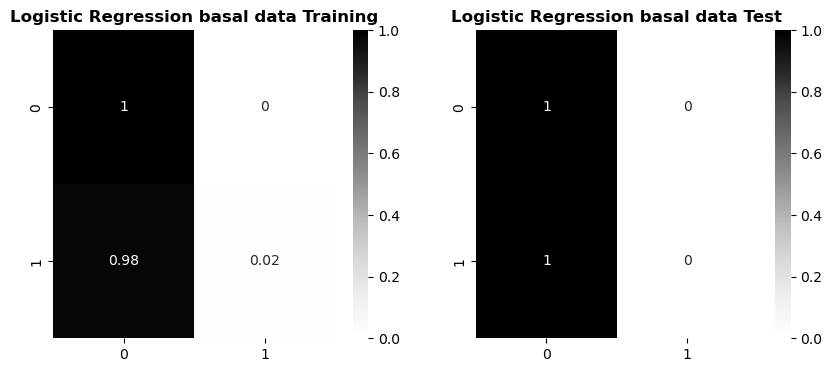

In [15]:
lr.info_model(lr_model)

### 1.1 Random undersampling

In [16]:
logreg = LogisticRegression(random_state=20)
param_grid = {'C': [0.001, 0.01], 
              'max_iter': [100, 200],
              'solver':['sag', 'saga']}

In [17]:
lr_rus = Classification_report(X_train_rus, X_test, y_train_rus, y_test, 'Logistic Regression undersampling')

In [18]:
lr_rus_model = lr_rus.obtain_model(logreg, param_grid)
lr_rus_model

Best estimator for Logistic Regression undersampling found by grid search:
{'C': 0.01, 'max_iter': 200, 'solver': 'saga'}


LogisticRegression(C=0.01, max_iter=200, random_state=20, solver='saga')

Mean Validation Classification Accuracy:  0.6556396396396397
accuracy: 0.6848214285714286
F1 score: 0.22075055187637968
Recall: 0.5681818181818182


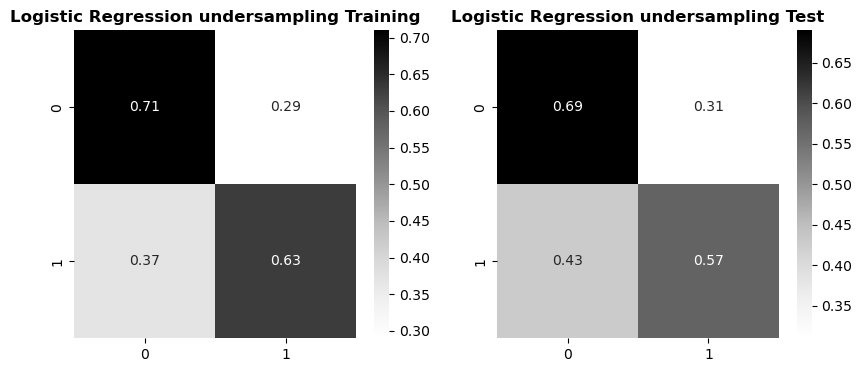

In [19]:
lr_rus.info_model(lr_rus_model)

### 1.2 Random oversampling

In [20]:
logreg = LogisticRegression(random_state=20)
param_grid = {'C': [0.001, 0.01], 
              'max_iter': [100, 200],
              'solver':['sag', 'saga']}

In [21]:
lr_ros = Classification_report(X_train_ros, X_test, y_train_ros, y_test, 'Logistic Regression oversampling')

In [22]:
lr_ros_model = lr_ros.obtain_model(logreg, param_grid)
lr_ros_model

Best estimator for Logistic Regression oversampling found by grid search:
{'C': 0.01, 'max_iter': 100, 'solver': 'saga'}


LogisticRegression(C=0.01, random_state=20, solver='saga')

Mean Validation Classification Accuracy:  0.6859926918392205
accuracy: 0.7098214285714286
F1 score: 0.2459396751740139
Recall: 0.6022727272727273


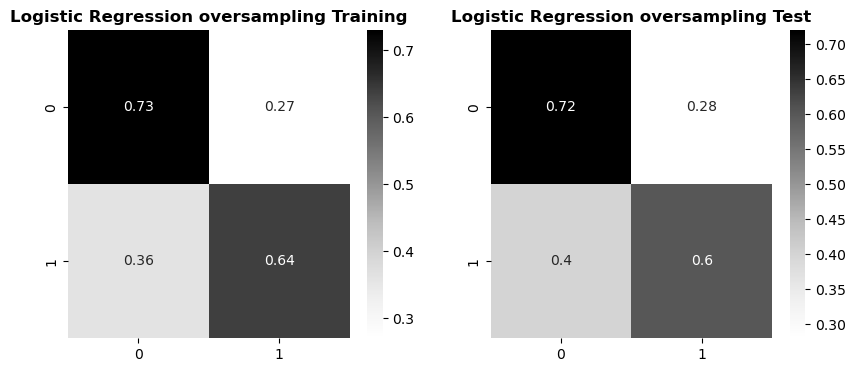

In [23]:
lr_ros.info_model(lr_ros_model)

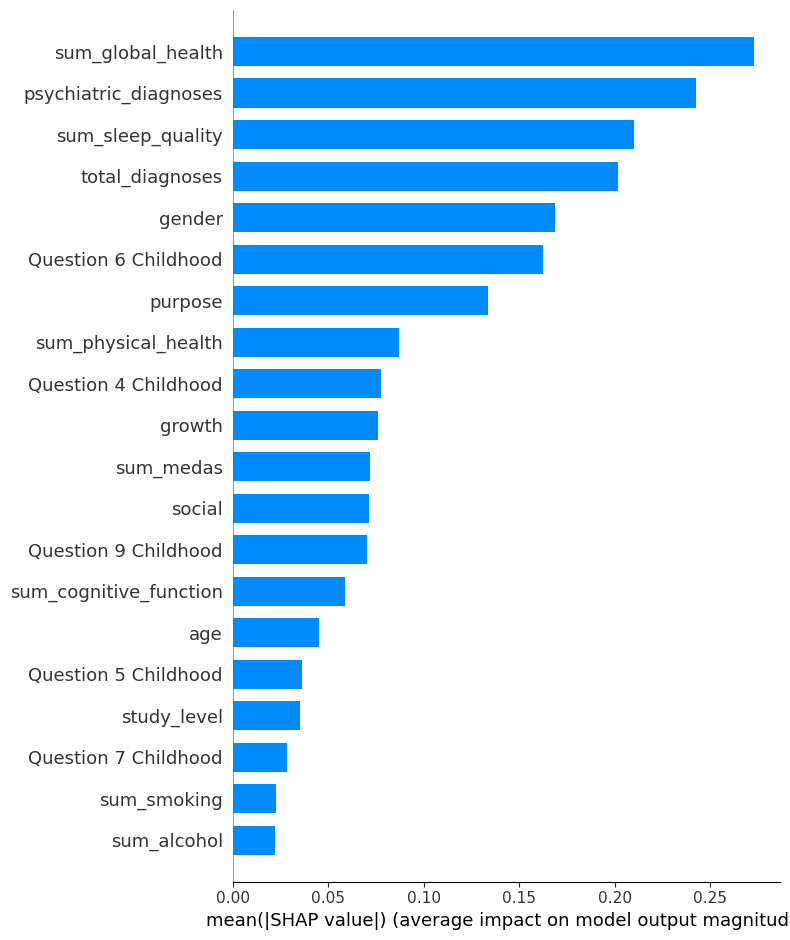

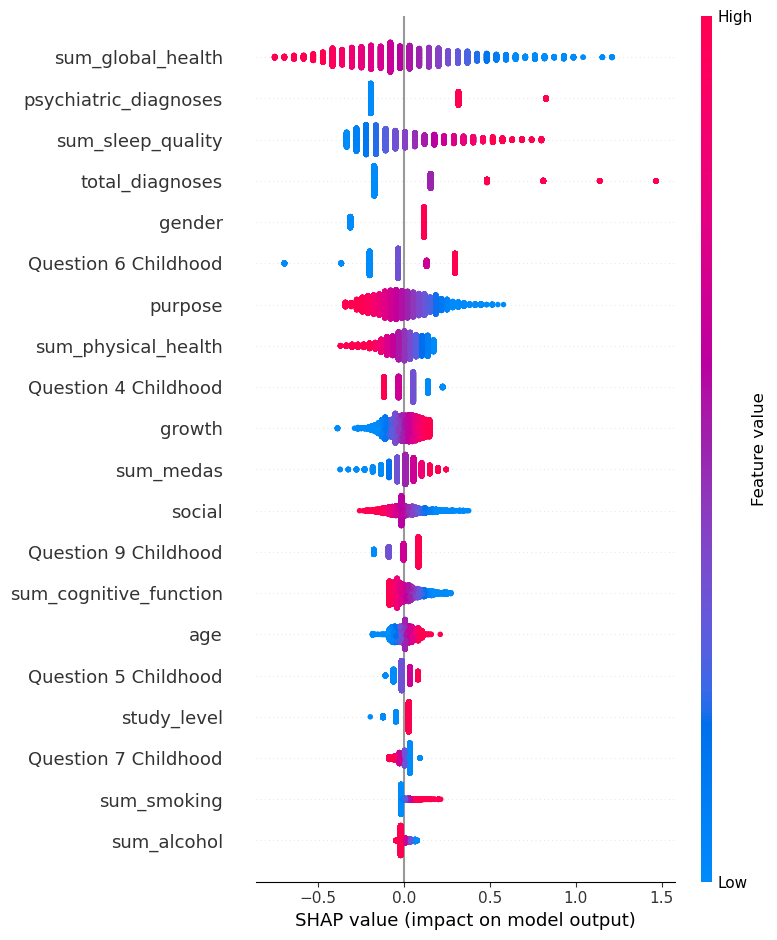

In [24]:
lr_ros.factors_report(lr_ros_model)

### 1.3 Logistic regression/Random oversampling by gender

In [25]:
men = df[df['gender']==1]
women = df[df['gender']==2]

In [26]:
mX = men.drop(men.columns[[0, 1, 5, 16]], axis=1)
my = np.ravel(men.iloc[:,[16]])

wX = women.drop(women.columns[[0, 1, 5, 16]], axis=1)
wy = np.ravel(women.iloc[:,[16]])

random_state = 20

mX_train, mX_test, my_train, my_test = train_test_split(
    mX, my, test_size=0.2, random_state=random_state)

wX_train, wX_test, wy_train, wy_test = train_test_split(
    wX, wy, test_size=0.2, random_state=random_state)

In [27]:
mX_train_rus, my_train_rus = rus.fit_resample(mX_train, my_train)
wX_train_rus, wy_train_rus = rus.fit_resample(wX_train, wy_train)

mX_train_ros, my_train_ros = ros.fit_resample(mX_train, my_train)
wX_train_ros, wy_train_ros = ros.fit_resample(wX_train, wy_train)

#### 1.3.1 Men's model

In [28]:
logreg = LogisticRegression(random_state=20)
param_grid = {'C': [0.001, 0.01], 
              'max_iter': [100, 200],
              'solver':['sag', 'saga']}

In [29]:
lr_ros_men = Classification_report(mX_train_ros, mX_test, my_train_ros, my_test, "Logistic Regression ROS (men)")

In [30]:
lr_ros_men_model = lr_ros_men.obtain_model(logreg, param_grid)
lr_ros_men_model

Best estimator for Logistic Regression ROS (men) found by grid search:
{'C': 0.01, 'max_iter': 200, 'solver': 'sag'}


LogisticRegression(C=0.01, max_iter=200, random_state=20, solver='sag')

Mean Validation Classification Accuracy:  0.6726152832674572
accuracy: 0.6842105263157895
F1 score: 0.109375
Recall: 0.5


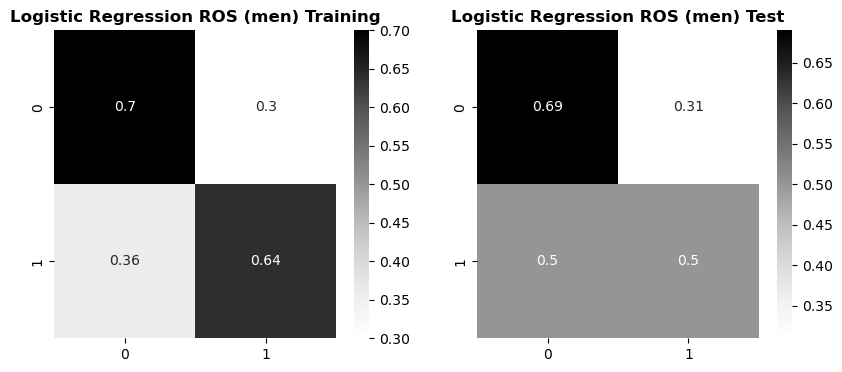

In [31]:
lr_ros_men.info_model(lr_ros_men_model)

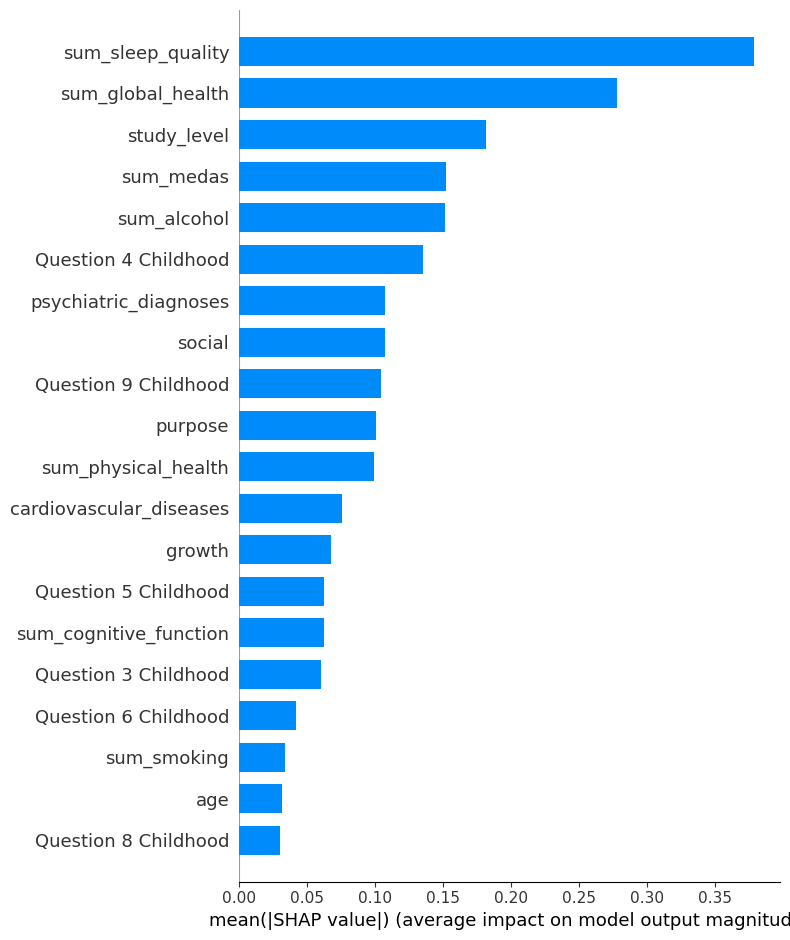

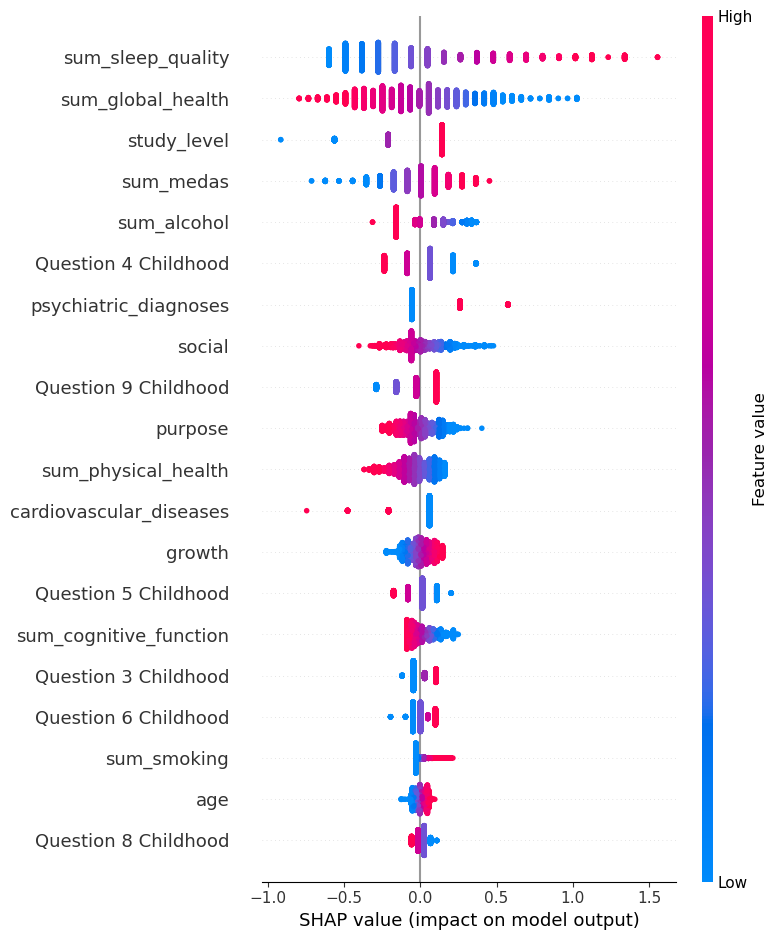

In [32]:
lr_ros_men.factors_report(lr_ros_men_model)

#### 1.3.2 Women's model

In [33]:
logreg = LogisticRegression(random_state=20)
param_grid = {'C': [0.001, 0.01], 
              'max_iter': [100, 200],
              'solver':['sag', 'saga']}

In [34]:
lr_ros_women = Classification_report(wX_train_ros, wX_test, wy_train_ros, wy_test, "Logistic Regression ROS (women)")

In [35]:
lr_ros_women_model = lr_ros_women.obtain_model(logreg, param_grid)
lr_ros_women_model

Best estimator for Logistic Regression ROS (women) found by grid search:
{'C': 0.01, 'max_iter': 100, 'solver': 'saga'}


LogisticRegression(C=0.01, random_state=20, solver='saga')

Mean Validation Classification Accuracy:  0.6817671706321141
accuracy: 0.7193675889328063
F1 score: 0.3194888178913738
Recall: 0.6097560975609756


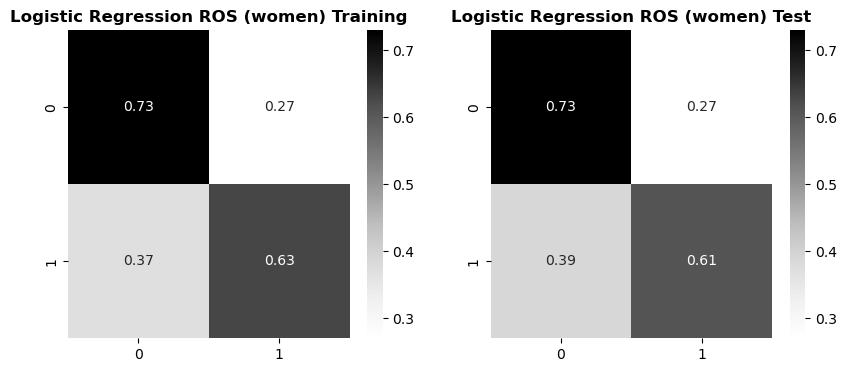

In [36]:
lr_ros_women.info_model(lr_ros_women_model)

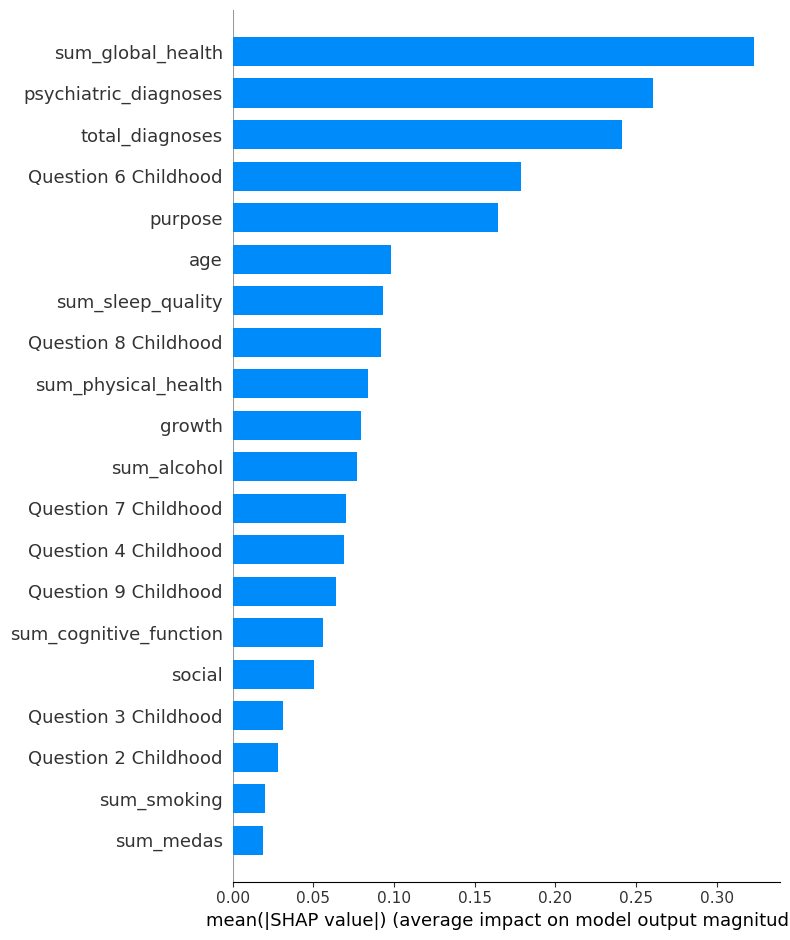

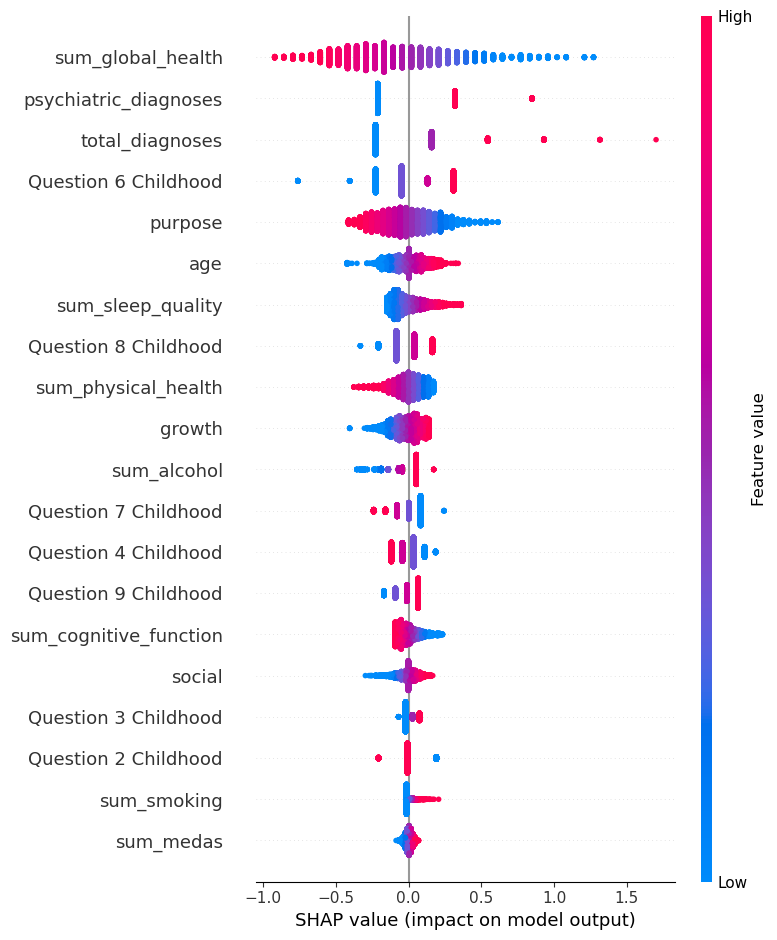

In [37]:
lr_ros_women.factors_report(lr_ros_women_model)

## 2. Random forest

In [38]:
rfc = RandomForestClassifier(random_state=20)
param_grid = {'min_samples_leaf': [1,2],
              'min_samples_split': [2,5,10],
              'max_depth': [8,10,15],
              'criterion':['entropy','gini'],
              'n_estimators': [25, 50, 100]} 

In [39]:
rf = Classification_report(X_train, X_test, y_train, y_test, 'Random Forest basal data')

In [40]:
rf_model = rf.obtain_model(rfc, param_grid)
rf_model

Best estimator for Random Forest basal data found by grid search:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50,
                       random_state=20)

Mean Validation Classification Accuracy:  0.9169278323745607
accuracy: 0.91875
F1 score: 0.0
Recall: 0.0


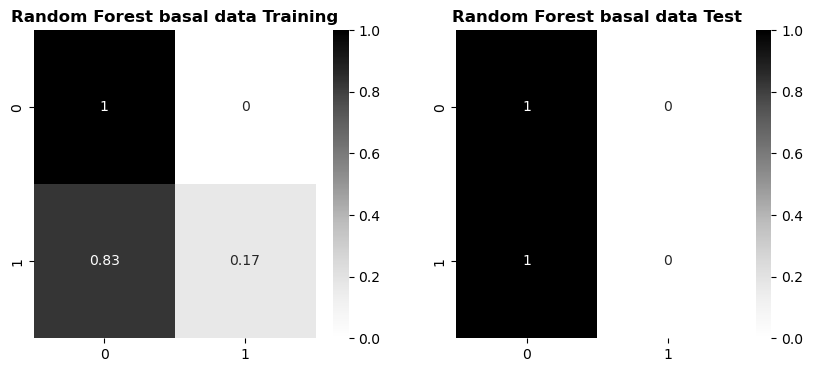

In [41]:
rf.info_model(rf_model)

### 2.1 Random undersampling

In [42]:
rfc = RandomForestClassifier(random_state=20)
param_grid = {'min_samples_leaf': [1,2],
              'min_samples_split': [2,5,10],
              'max_depth': [8,10,15],
              'criterion':['entropy','gini'],
              'n_estimators': [25, 50, 100]} 

In [43]:
rf_rus = Classification_report(X_train_rus, X_test, y_train_rus, y_test, 'Random Forest RUS')

In [44]:
rf_rus_model = rf_rus.obtain_model(rfc, param_grid)
random_forest.append(rf_rus_model)
rf_rus_model

Best estimator for Random Forest RUS found by grid search:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 25}


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=25, random_state=20)

Mean Validation Classification Accuracy:  0.6892072072072073
accuracy: 0.675
F1 score: 0.2320675105485232
Recall: 0.625


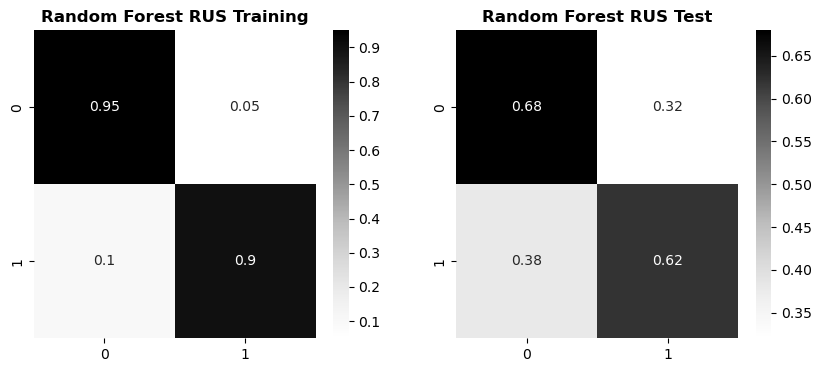

In [45]:
rf_rus.info_model(rf_rus_model)

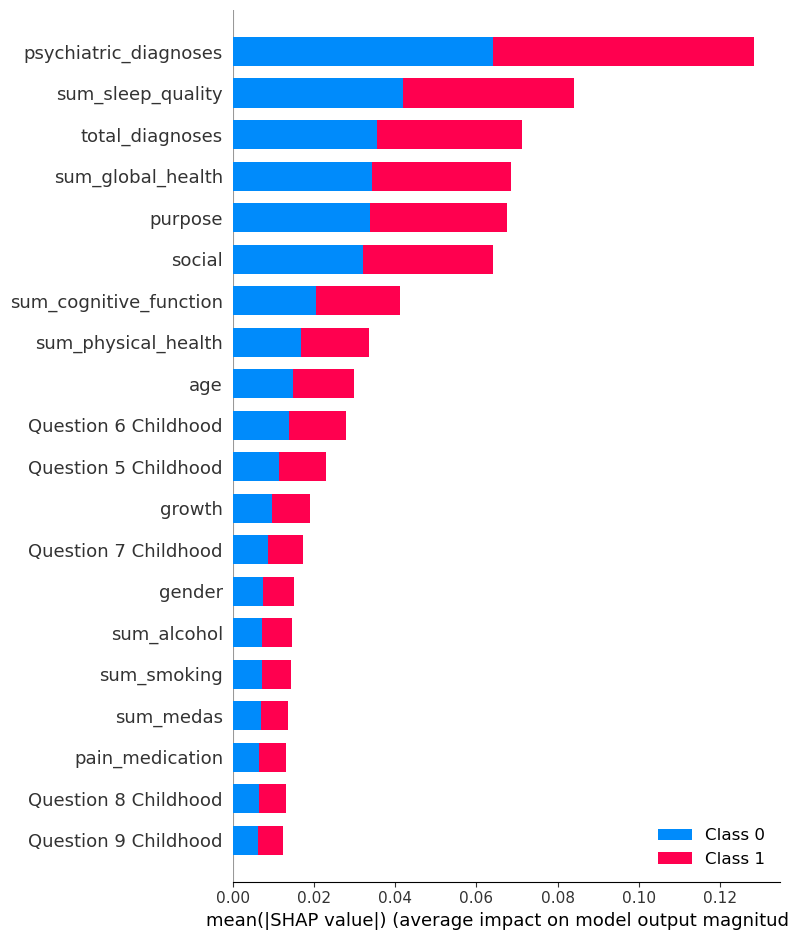

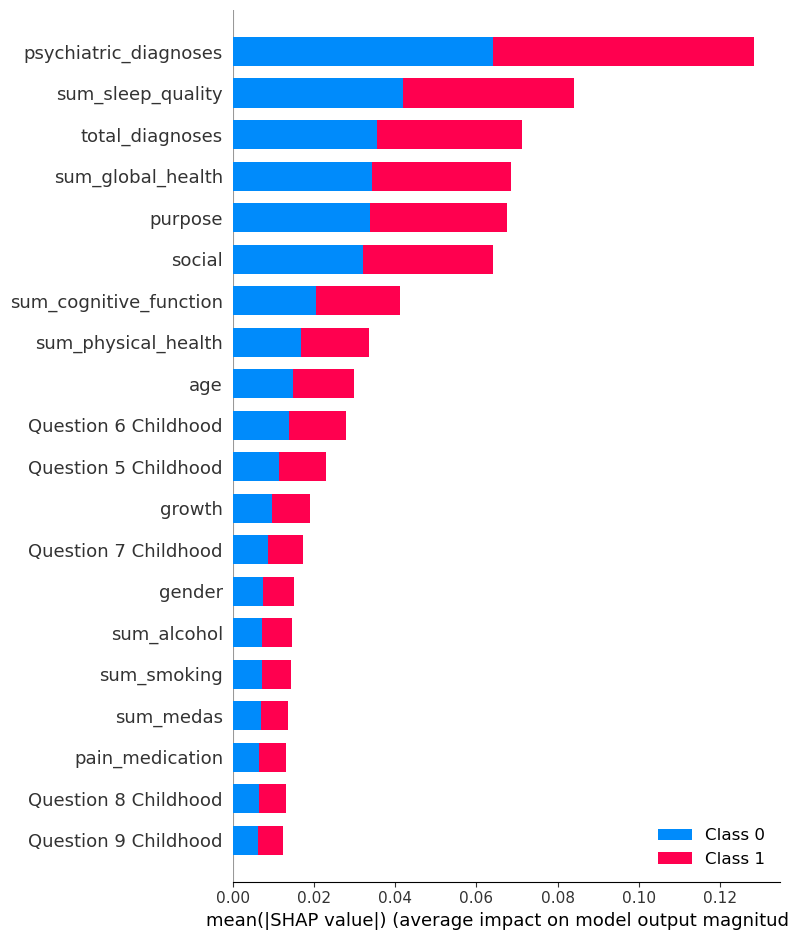

In [46]:
rf_rus.factors_report(rf_rus_model)

### 2.2 Random oversampling

In [47]:
rfc = RandomForestClassifier(random_state=20)
param_grid = {'min_samples_leaf': [1,2],
              'min_samples_split': [2,5,10],
              'max_depth': [8,10,15],
              'criterion':['entropy','gini'],
              'n_estimators': [25, 50, 100]} 

In [48]:
rf_ros = Classification_report(X_train_ros, X_test, y_train_ros, y_test, 'Random Forest ROS')

In [49]:
rf_ros_model = rf_ros.obtain_model(rfc, param_grid)
rf_ros_model

Best estimator for Random Forest ROS found by grid search:
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(criterion='entropy', max_depth=15, random_state=20)

Mean Validation Classification Accuracy:  0.98952496954933
accuracy: 0.9142857142857143
F1 score: 0.17241379310344826
Recall: 0.11363636363636363


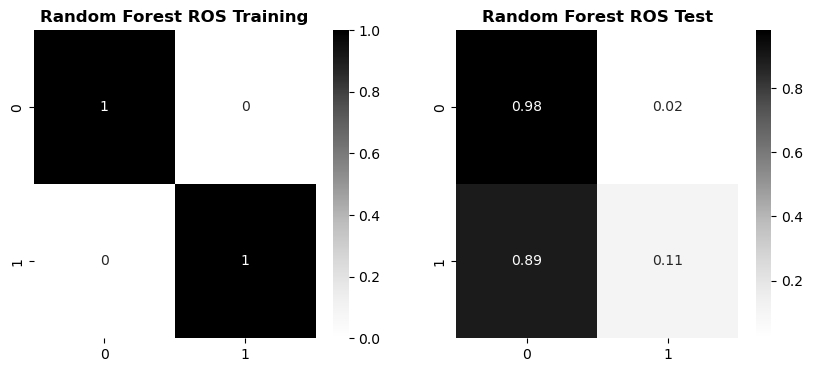

In [50]:
rf_ros.info_model(rf_ros_model)

### 2.3 Random forest/Random undersampling by gender

#### 2.3.1 Men's model 

In [51]:
rfc = RandomForestClassifier(random_state=20)
param_grid = {'min_samples_leaf': [1,2],
              'min_samples_split': [2,5,10],
              'max_depth': [8,10,15],
              'criterion':['entropy','gini'],
              'n_estimators': [25, 50, 100]} 

In [52]:
rf_rus_men = Classification_report(mX_train_rus, mX_test, my_train_rus, my_test, 'Random Forest RUS (men)')

In [53]:
rf_rus_men_model = rf_rus_men.obtain_model(rfc, param_grid)
random_forest.append(rf_rus_men_model)
rf_rus_men_model

Best estimator for Random Forest RUS (men) found by grid search:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50, random_state=20)

Mean Validation Classification Accuracy:  0.6681318681318681
accuracy: 0.5872576177285319
F1 score: 0.11834319526627218
Recall: 0.7142857142857143


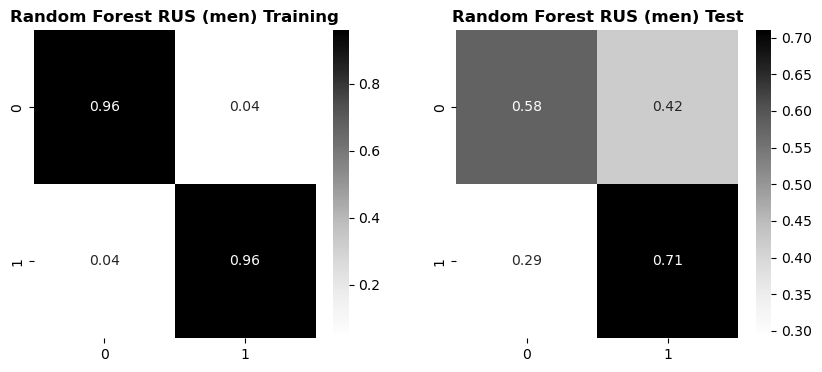

In [54]:
rf_rus_men.info_model(rf_rus_men_model)

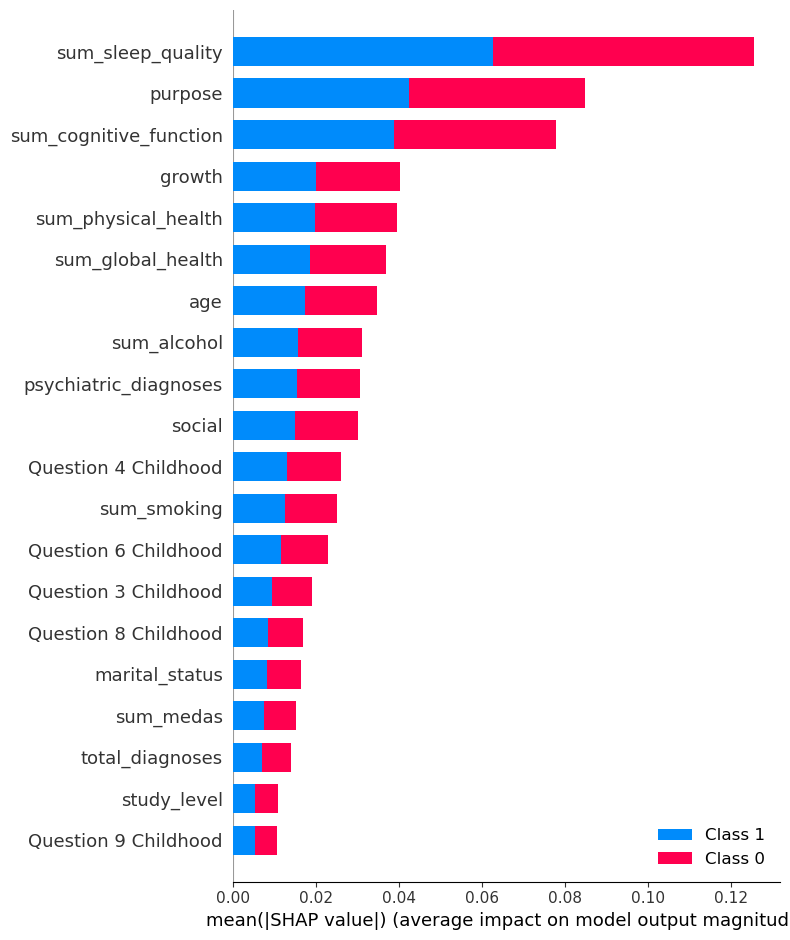

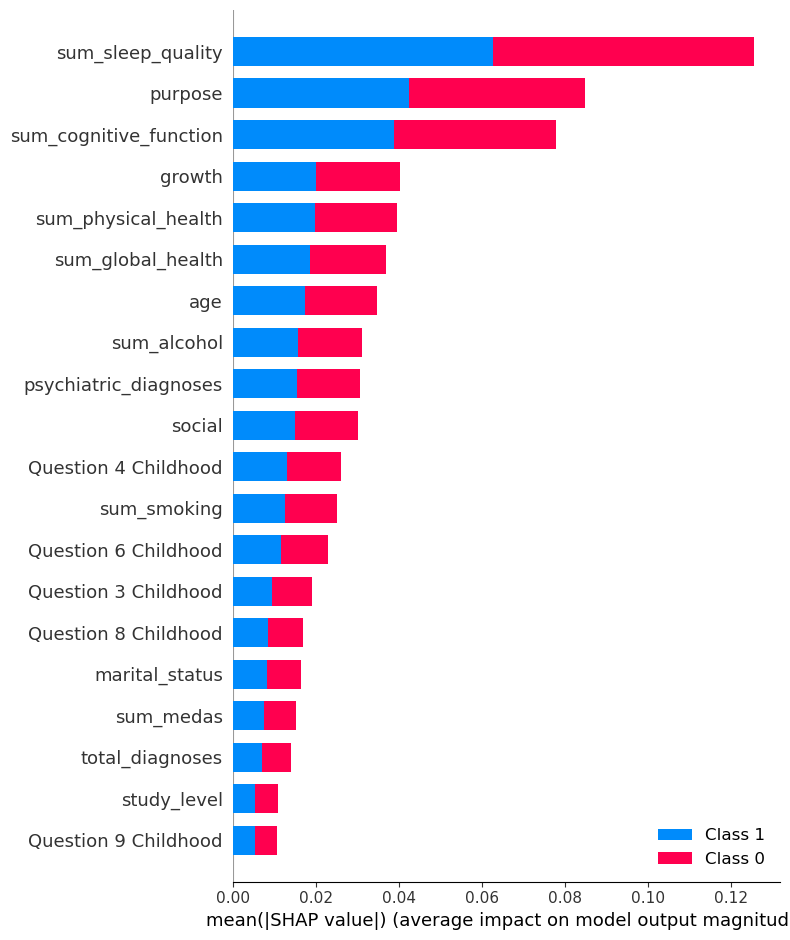

In [55]:
rf_rus_men.factors_report(rf_rus_men_model)

#### 2.3.2 Women's model

In [56]:
rfc = RandomForestClassifier(random_state=20)
param_grid = {'min_samples_leaf': [1,2],
              'min_samples_split': [2,5,10],
              'max_depth': [8,10,15],
              'criterion':['entropy','gini'],
              'n_estimators': [25, 50, 100]} 

In [57]:
rf_rus_women = Classification_report(wX_train_rus, wX_test, wy_train_rus, wy_test, 'Random Forest RUS (women)')

In [58]:
rf_rus_women_model = rf_rus_women.obtain_model(rfc, param_grid)
random_forest.append(rf_rus_women_model)
rf_rus_women_model

Best estimator for Random Forest RUS (women) found by grid search:
{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=50,
                       random_state=20)

Mean Validation Classification Accuracy:  0.6888135593220338
accuracy: 0.6785243741765481
F1 score: 0.3028571428571429
Recall: 0.6463414634146342


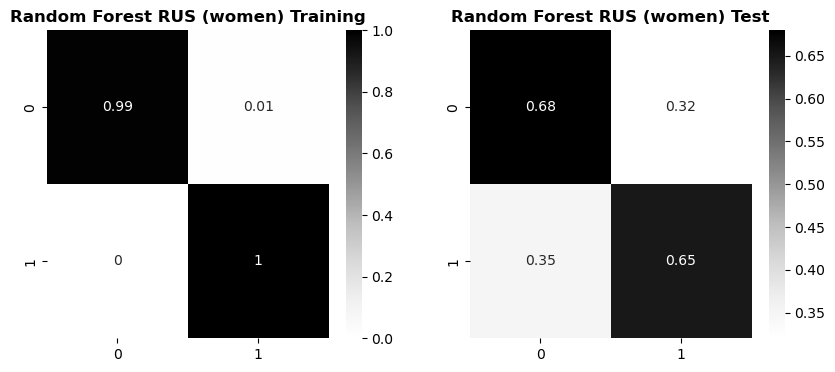

In [59]:
rf_rus_women.info_model(rf_rus_women_model)

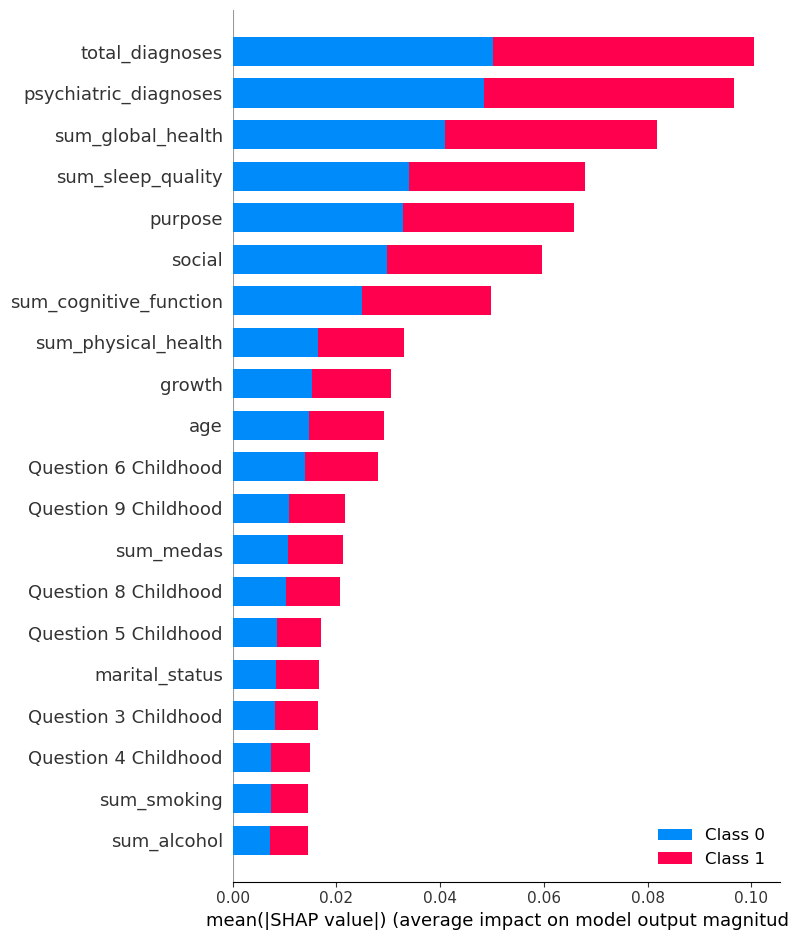

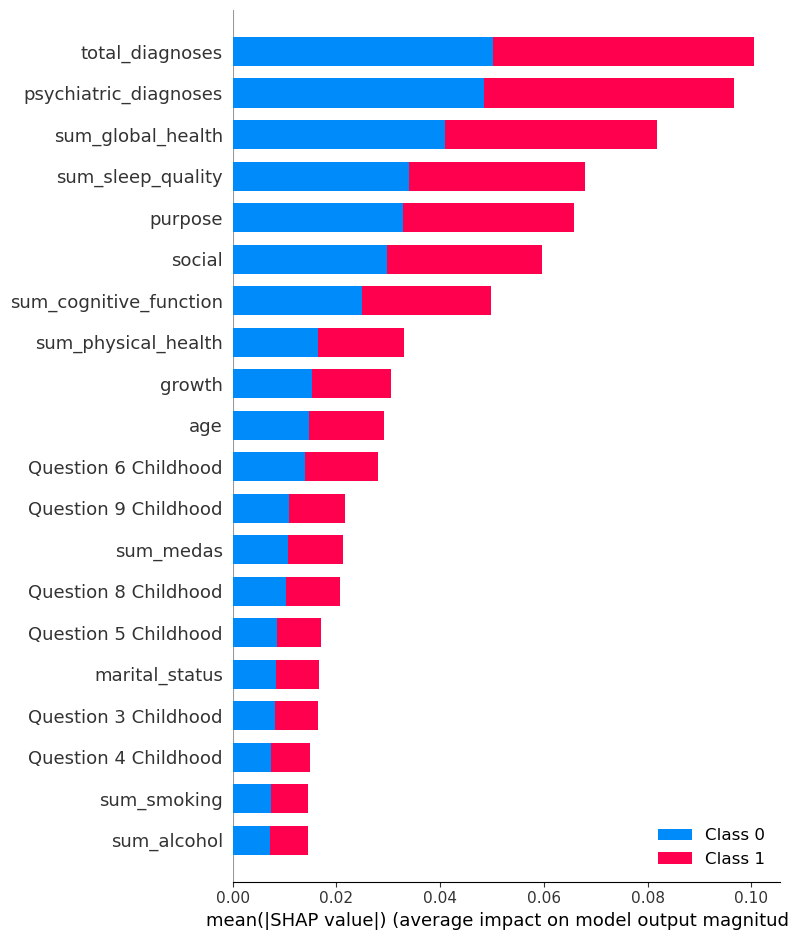

In [60]:
rf_rus_women.factors_report(rf_rus_women_model)

## 3. Gradient boosting

In [61]:
gbc = GradientBoostingClassifier(random_state=20)
param_grid = {'min_samples_leaf': [2,5,10],
              'min_samples_split': [2,5,10],
              'max_depth': [2,4,6],
              'n_estimators': [50, 100],
              'learning_rate': [0.1, 1, 5]} 

In [62]:
gb = Classification_report(X_train, X_test, y_train, y_test, 'Gradient Boosting basal data')

In [63]:
gb_model = gb.obtain_model(gbc, param_grid)
gb_model

Best estimator for Gradient Boosting basal data found by grid search:
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}


GradientBoostingClassifier(max_depth=2, min_samples_leaf=10, random_state=20)

Mean Validation Classification Accuracy:  0.9164794063598594
accuracy: 0.91875
F1 score: 0.0
Recall: 0.0


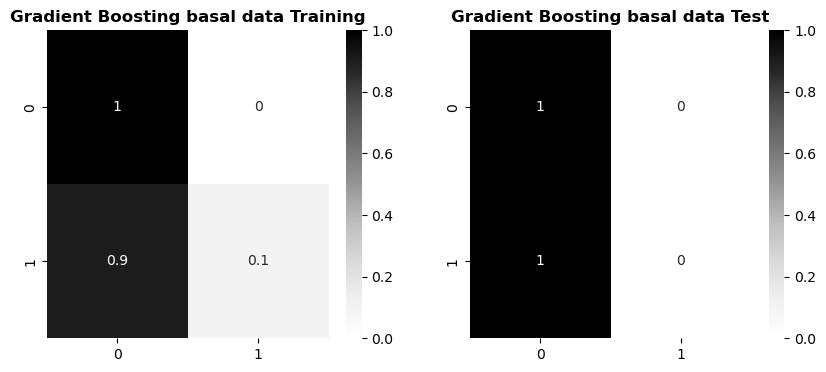

In [64]:
gb.info_model(gb_model)

### 3.1 Random undersampling

In [65]:
gbc = GradientBoostingClassifier(random_state=20)
param_grid = {'min_samples_leaf': [2,5,10],
              'min_samples_split': [2,5,10],
              'max_depth': [2,4,6],
              'n_estimators': [50, 100],
              'learning_rate': [0.1, 1, 5]} 

In [66]:
gb_rus = Classification_report(X_train_rus, X_test, y_train_rus, y_test, 'Gradient Boosting RUS')

In [67]:
gb_rus_model = gb_rus.obtain_model(gbc, param_grid)
gb_rus_model

Best estimator for Gradient Boosting RUS found by grid search:
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}


GradientBoostingClassifier(max_depth=2, min_samples_leaf=5, n_estimators=50,
                           random_state=20)

Mean Validation Classification Accuracy:  0.6985225225225224
accuracy: 0.6848214285714286
F1 score: 0.23427331887201738
Recall: 0.6136363636363636


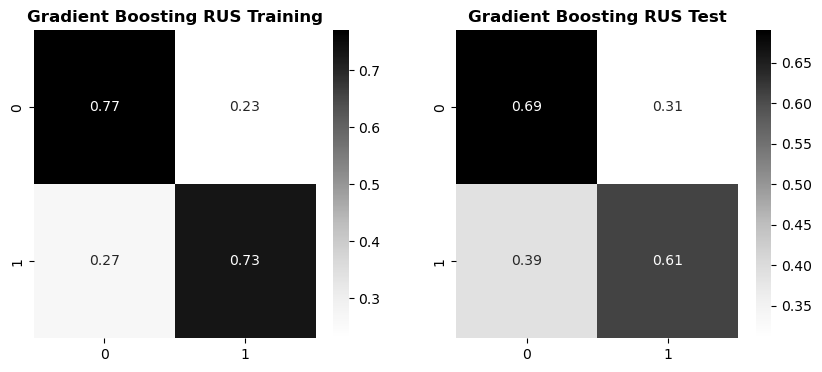

In [68]:
gb_rus.info_model(gb_rus_model)

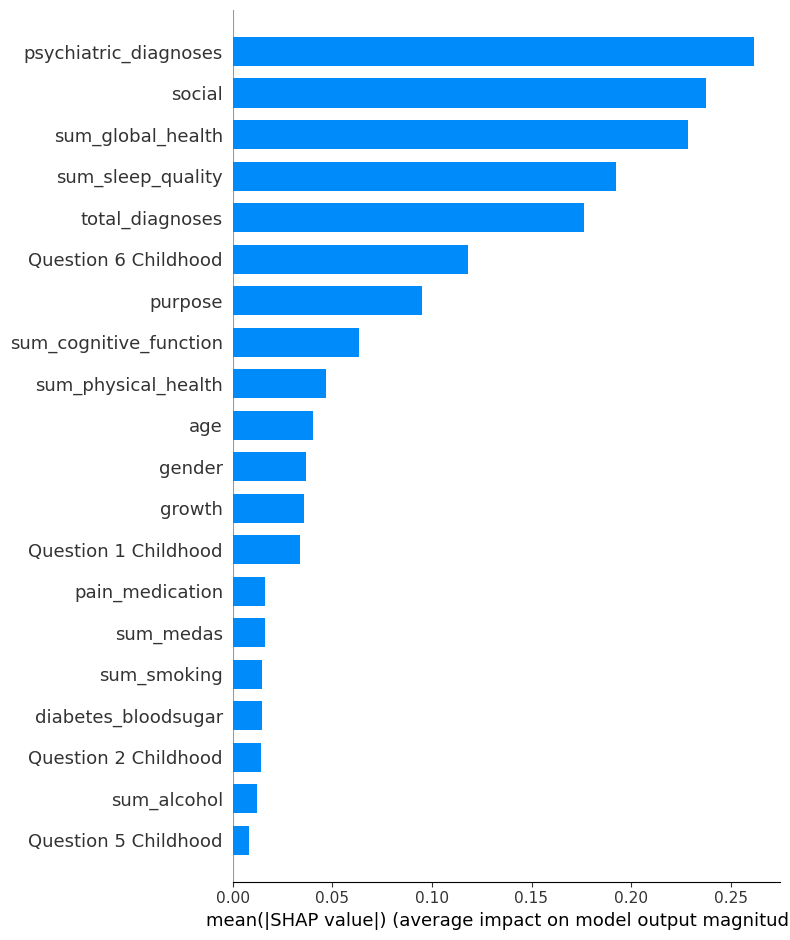

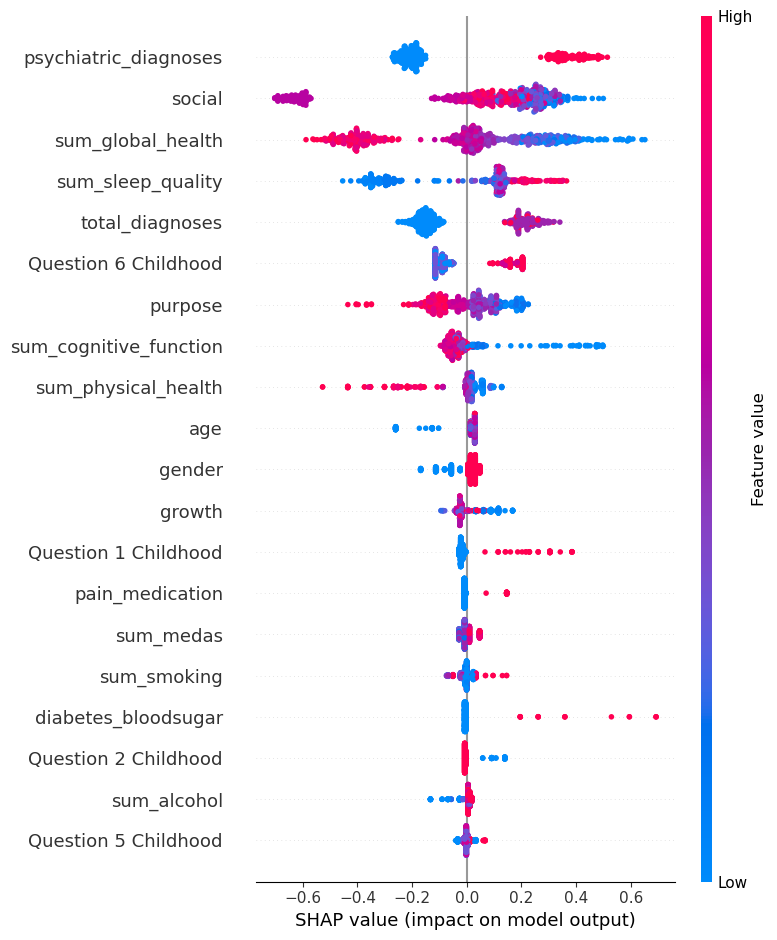

In [69]:
gb_rus.factors_report(gb_rus_model)

### 3.2 Random oversampling

In [70]:
gbc = GradientBoostingClassifier(random_state=20)
param_grid = {'min_samples_leaf': [2,5,10],
              'min_samples_split': [2,5,10],
              'max_depth': [2,4,6],
              'n_estimators': [50, 100],
              'learning_rate': [0.1, 1, 5]} 

In [71]:
gb_ros = Classification_report(X_train_ros, X_test, y_train_ros, y_test, 'Gradient Boosting ROS')

In [72]:
gb_ros_model = gb_ros.obtain_model(gbc, param_grid)
gb_ros_model

Best estimator for Gradient Boosting ROS found by grid search:
{'learning_rate': 1, 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


GradientBoostingClassifier(learning_rate=1, max_depth=6, min_samples_leaf=5,
                           random_state=20)

Mean Validation Classification Accuracy:  0.9850182704019488
accuracy: 0.9017857142857143
F1 score: 0.14062500000000003
Recall: 0.10227272727272728


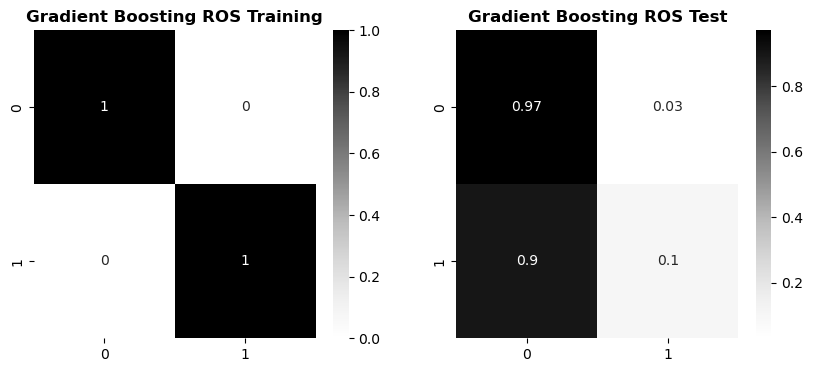

In [73]:
gb_ros.info_model(gb_ros_model)

### 3.3 Gradient boosting/Random undersampling by gender

#### 3.3.1 Men's model

In [74]:
gbc = GradientBoostingClassifier(random_state=20)
param_grid = {'min_samples_leaf': [2,5,10],
              'min_samples_split': [2,5,10],
              'max_depth': [2,4,6],
              'n_estimators': [50, 100],
              'learning_rate': [0.1, 1, 5]} 

In [75]:
gb_rus_men = Classification_report(mX_train_rus, mX_test, my_train_rus, my_test, "Gradient Boosting RUS (men)")

In [76]:
gb_rus_men_model = gb_rus_men.obtain_model(gbc, param_grid)
gb_rus_men_model

Best estimator for Gradient Boosting RUS (men) found by grid search:
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


GradientBoostingClassifier(max_depth=2, min_samples_leaf=2, min_samples_split=5,
                           n_estimators=50, random_state=20)

Mean Validation Classification Accuracy:  0.6692307692307692
accuracy: 0.6011080332409973
F1 score: 0.12195121951219512
Recall: 0.7142857142857143


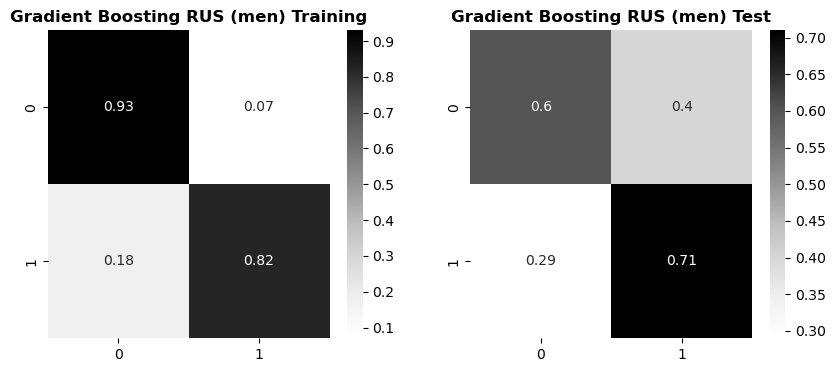

In [77]:
gb_rus_men.info_model(gb_rus_men_model)

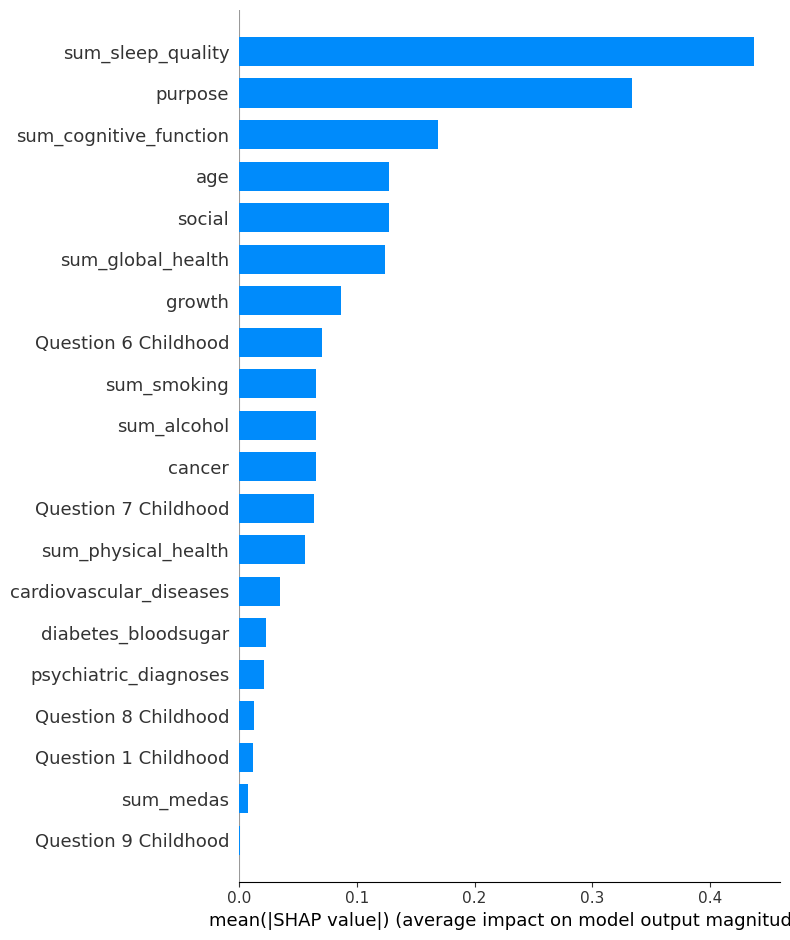

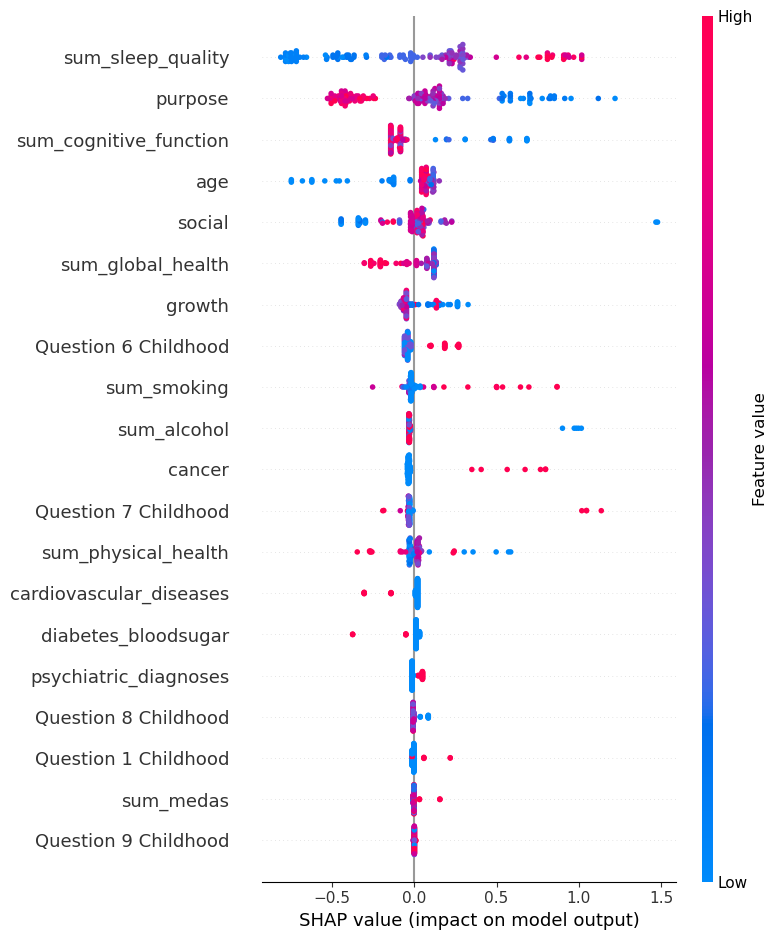

In [78]:
gb_rus_men.factors_report(gb_rus_men_model)

#### 3.3.2 Women's model

In [79]:
gbc = GradientBoostingClassifier(random_state=20)
param_grid = {'min_samples_leaf': [2,5,10],
              'min_samples_split': [2,5,10],
              'max_depth': [2,4,6],
              'n_estimators': [50, 100],
              'learning_rate': [0.1, 1, 5]} 

In [80]:
gb_rus_women = Classification_report(wX_train_rus, wX_test, wy_train_rus, wy_test, "Gradient Boosting RUS (women)")

In [81]:
gb_rus_women_model = gb_rus_women.obtain_model(gbc, param_grid)
gb_rus_women_model

Best estimator for Gradient Boosting RUS (women) found by grid search:
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


GradientBoostingClassifier(max_depth=2, min_samples_leaf=2, min_samples_split=5,
                           random_state=20)

Mean Validation Classification Accuracy:  0.671864406779661
accuracy: 0.691699604743083
F1 score: 0.31578947368421056
Recall: 0.6585365853658537


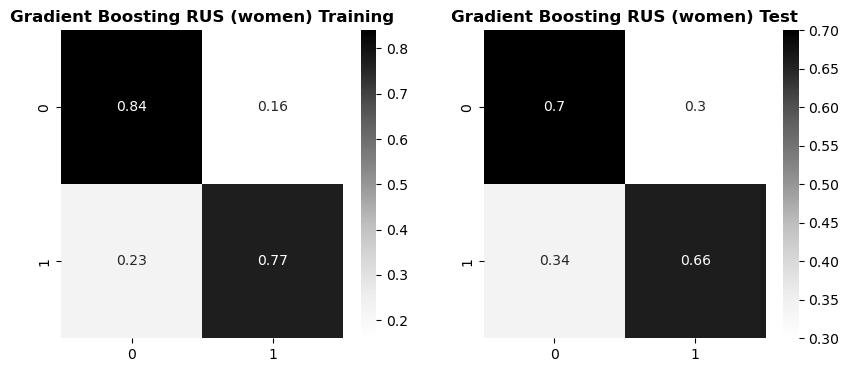

In [82]:
gb_rus_women.info_model(gb_rus_women_model)

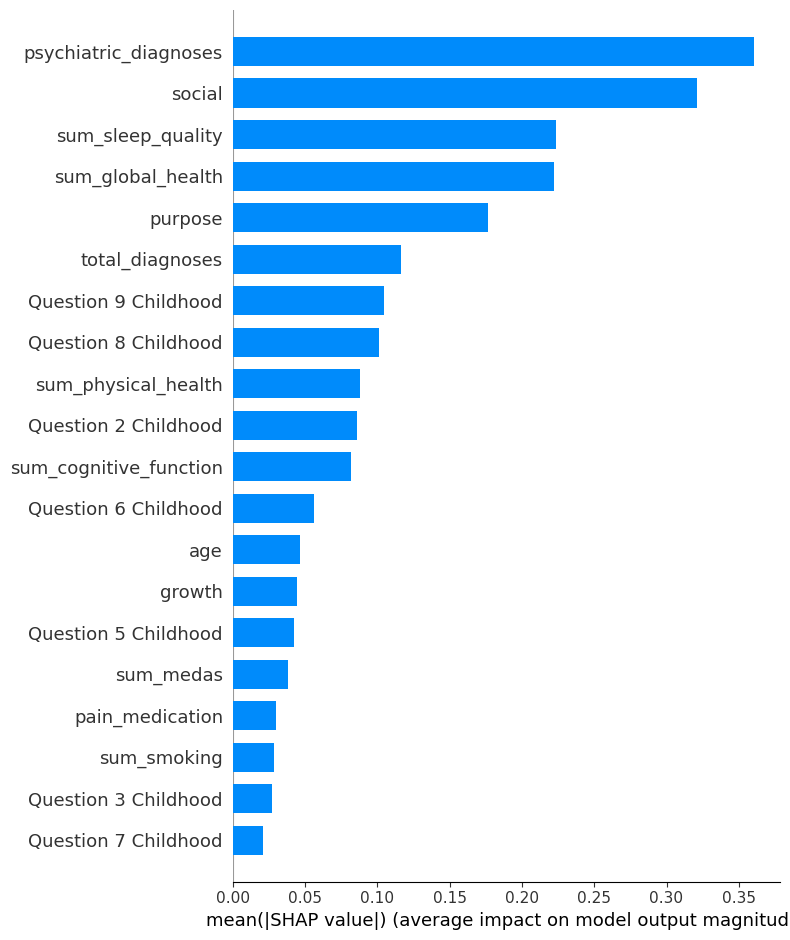

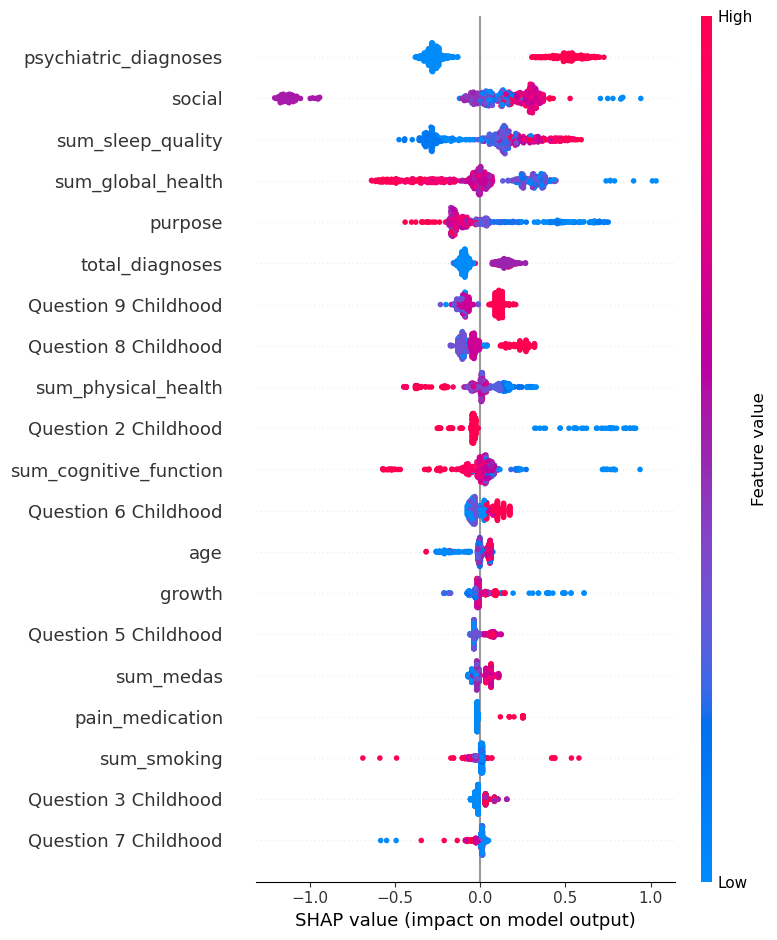

In [83]:
gb_rus_women.factors_report(gb_rus_women_model)

## 4. KNN

In [84]:
knnc = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 21))}

In [85]:
knn = Classification_report(X_train, X_test, y_train, y_test, 'K-nearest neighbours basal data')

In [86]:
knn_model = knn.obtain_model(knnc, param_grid)
knn_model

Best estimator for K-nearest neighbours basal data found by grid search:
{'n_neighbors': 20}


KNeighborsClassifier(n_neighbors=20)

Mean Validation Classification Accuracy:  0.9167041187280282
accuracy: 0.9214285714285714
F1 score: 0.0
Recall: 0.0


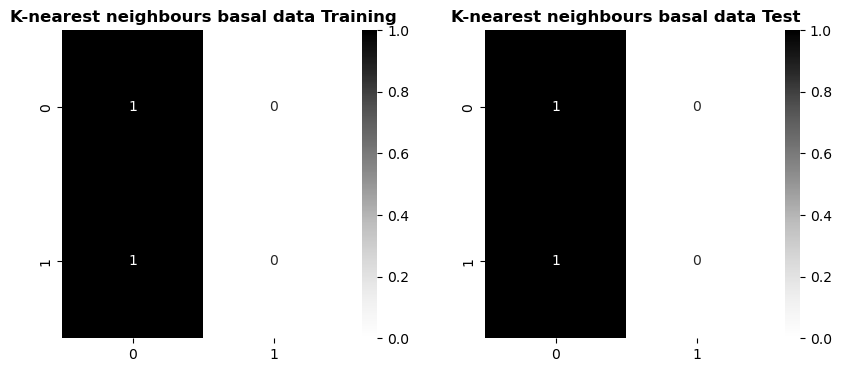

In [87]:
knn.info_model(knn_model)

### 4.1 Random undersampling

In [88]:
knnc = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 21))}

In [89]:
knn_rus = Classification_report(X_train_rus, X_test, y_train_rus, y_test, 'K-nearest neighbours RUS')

In [90]:
knn_rus_model = knn_rus.obtain_model(knnc, param_grid)
knn_rus_model

Best estimator for K-nearest neighbours RUS found by grid search:
{'n_neighbors': 7}


KNeighborsClassifier(n_neighbors=7)

Mean Validation Classification Accuracy:  0.6463423423423423
accuracy: 0.6241071428571429
F1 score: 0.1825242718446602
Recall: 0.5340909090909091


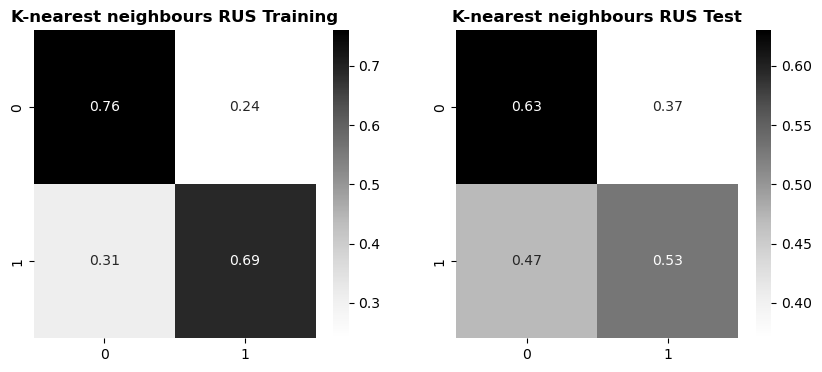

In [91]:
knn_rus.info_model(knn_rus_model)

### 4.2 Random oversampling

In [92]:
knnc = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 21))}

In [93]:
knn_ros = Classification_report(X_train_ros, X_test, y_train_ros, y_test, 'K-nearest neighbours ROS')

In [94]:
knn_ros_model = knn_ros.obtain_model(knnc, param_grid)
knn_ros_model

Best estimator for K-nearest neighbours ROS found by grid search:
{'n_neighbors': 2}


KNeighborsClassifier(n_neighbors=2)

Mean Validation Classification Accuracy:  0.9573690621193667
accuracy: 0.8517857142857143
F1 score: 0.07777777777777779
Recall: 0.07954545454545454


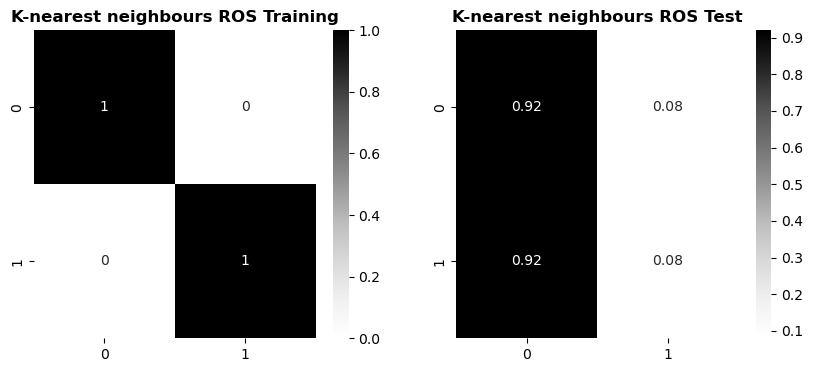

In [95]:
knn_ros.info_model(knn_ros_model)

## 5. Multilayer perceptron

In [96]:
mlpc = MLPClassifier(random_state=20)
param_grid = {'max_iter': [5000],
              'hidden_layer_sizes': [50, 100],
              'solver': ['lbfgs', 'adam'], 
              'activation': ['identity', 'logistic', 'tanh', 'relu']}

In [97]:
mlp = Classification_report(X_train, X_test, y_train, y_test, 'Multilayer perceptron basal data')

In [98]:
mlp_model = mlp.obtain_model(mlpc, param_grid)
mlp_model

Best estimator for Multilayer perceptron basal data found by grid search:
{'activation': 'identity', 'hidden_layer_sizes': 50, 'max_iter': 5000, 'solver': 'lbfgs'}


MLPClassifier(activation='identity', hidden_layer_sizes=50, max_iter=5000,
              random_state=20, solver='lbfgs')

Mean Validation Classification Accuracy:  0.9167041187280282
accuracy: 0.9214285714285714
F1 score: 0.0
Recall: 0.0


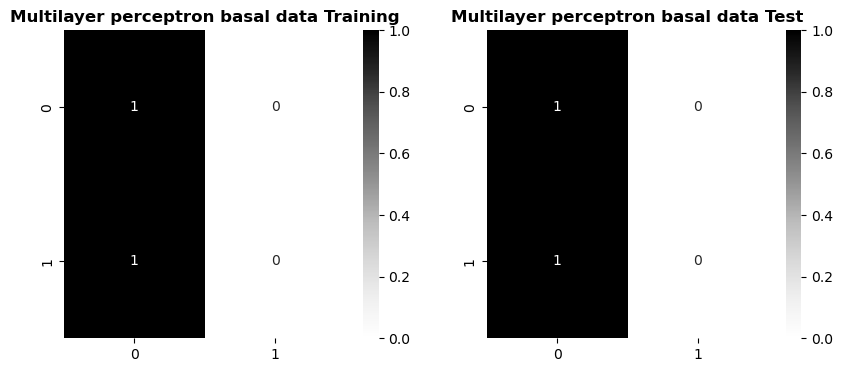

In [99]:
mlp.info_model(mlp_model)

### 5.1 Random undersampling

In [100]:
mlpc = MLPClassifier(random_state=20)
param_grid = {'max_iter': [5000],
              'hidden_layer_sizes': [50, 100],
              'solver': ['lbfgs', 'adam'], 
              'activation': ['identity', 'logistic', 'tanh', 'relu']}

In [101]:
mlp_rus = Classification_report(X_train_rus, X_test, y_train_rus, y_test, 'Multilayer perceptron RUS')

In [102]:
mlp_rus_model = mlp_rus.obtain_model(mlpc, param_grid)
mlp_rus_model

Best estimator for Multilayer perceptron RUS found by grid search:
{'activation': 'identity', 'hidden_layer_sizes': 50, 'max_iter': 5000, 'solver': 'adam'}


MLPClassifier(activation='identity', hidden_layer_sizes=50, max_iter=5000,
              random_state=20)

Mean Validation Classification Accuracy:  0.6851891891891893
accuracy: 0.7883928571428571
F1 score: 0.25705329153605017
Recall: 0.4659090909090909


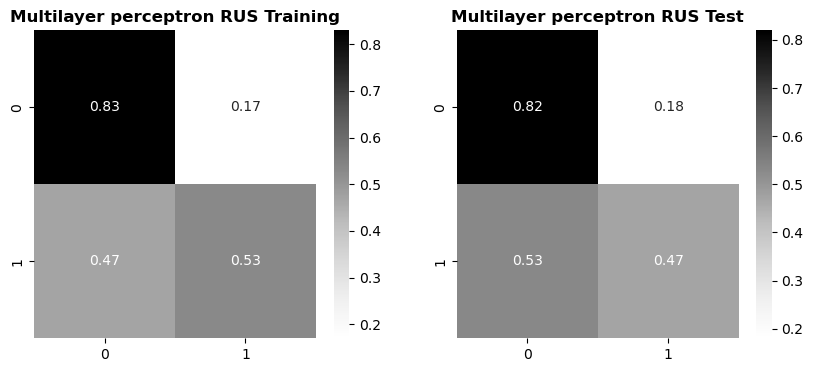

In [103]:
mlp_rus.info_model(mlp_rus_model)

### 5.2 Random oversampling

In [104]:
mlpc = MLPClassifier(random_state=20)
param_grid = {'max_iter': [5000],
              'hidden_layer_sizes': [50, 100],
              'solver': ['lbfgs', 'adam'], 
              'activation': ['identity', 'logistic', 'tanh', 'relu']}

In [105]:
mlp_ros = Classification_report(X_train_ros, X_test, y_train_ros, y_test, 'Multilayer perceptron ROS')

In [106]:
mlp_ros_model = mlp_ros.obtain_model(mlpc, param_grid)
mlp_ros_model

Best estimator for Multilayer perceptron ROS found by grid search:
{'activation': 'logistic', 'hidden_layer_sizes': 100, 'max_iter': 5000, 'solver': 'adam'}


MLPClassifier(activation='logistic', hidden_layer_sizes=100, max_iter=5000,
              random_state=20)

Mean Validation Classification Accuracy:  0.9624847746650426
accuracy: 0.8714285714285714
F1 score: 0.2577319587628866
Recall: 0.2840909090909091


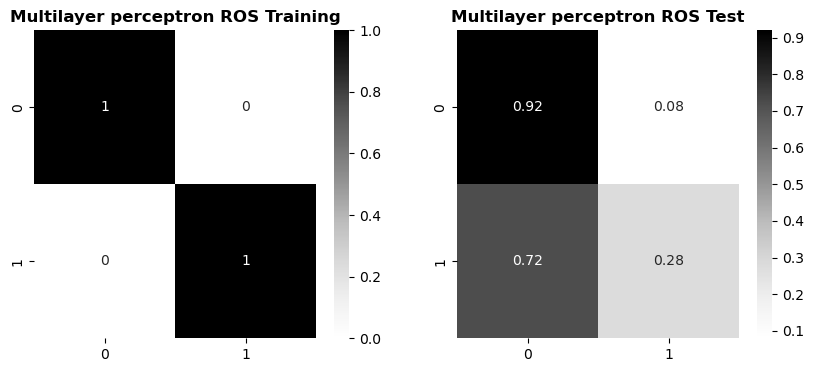

In [107]:
mlp_ros.info_model(mlp_ros_model)